## Analysis of USD/TRY Ratio btw 2016-2022
### Correlation analysis of the daily news with change in the ratio

Import required libraries

In [172]:
%matplotlib inline
import numpy as np
import datetime as dt
import warnings
import pandas as pd
from matplotlib import pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import power_transform
from sklearn.metrics import mean_squared_error

from bs4 import BeautifulSoup,SoupStrainer
import requests
import re
import time
from selenium import webdriver
from selenium.webdriver.common.by import By

warnings.filterwarnings("ignore")

## Scrape the history of USD/TRY ratio from yahoo finance 
### then update the latest price data with already created historical data

In [182]:
url2 = "https://finance.yahoo.com/quote/TRY%3DX/history?p=TRY%3DX"

headers = {"User-Agent": "Mozilla/5.0"}
source = requests.get(url2, headers=headers).text
soup = BeautifulSoup(source)

table = soup.table
table_rows = table.find_all('tr')
table_ls = []

for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    table_ls.append(row)

df = pd.DataFrame(table_ls)

new_cols = ['Date', 'Open', 'High', 'Low', 'Close', "Adj.Close", "Volume"]

new_names_map = {df.columns[i]: new_cols[i] for i in range(len(new_cols))}
df.rename(new_names_map, axis=1, inplace=True)


df2 = df.dropna(axis=0)

df2['Date'] = df2['Date'].str.strip()
df2['Date'] = pd.to_datetime(df2['Date'], format='%b %d, %Y') # format=YYYY-MM-DD


df2 = df2.set_index(df2["Date"].values)
df2 = df2.replace(",", "", regex=True)

df2[['Open', 'High', 'Low', 'Close', "Adj.Close"]] = df2[['Open', 'High', 'Low', 'Close', "Adj.Close"]].apply(
    pd.to_numeric)
    
df1 = pd.read_csv("TRY=X.csv",parse_dates=True, index_col=0)
df2['Date'] = pd.to_datetime(df2['Date'], format='%Y-%m-%d')  # format=YYYY-MM-DD
df2.set_index("Date",inplace=True,drop=True)
frames = [df1, df2]



In [197]:
result = pd.concat(frames).drop_duplicates().drop(["Adj.Close","Adj Close","Volume"],axis=1).sort_index()

In [240]:
result = result.groupby(result.index).first()
result["Day_Name"]=result.index.day_name()
result = result.asfreq("B",method="ffill")

result

,Open,High,Low,Close,Day_Name
Date,,,,,
2005-01-03,1.34550,1.34550,1.3368,1.34400,Monday
2005-01-04,1.33680,1.35100,1.3368,1.35100,Tuesday
2005-01-05,1.35450,1.38650,1.3545,1.37400,Wednesday
2005-01-06,1.37800,1.40580,1.3780,1.39250,Thursday
2005-01-07,1.38700,1.39400,1.3615,1.39400,Friday
...,...,...,...,...,...
2022-01-05,13.41890,13.63390,13.2673,13.41150,Wednesday
2022-01-06,13.68140,13.87080,13.4655,13.68800,Thursday
2022-01-07,13.80400,13.91630,13.7046,13.78210,Friday


## Format updated timeseries data
#### take business day data between 2016-2022 and apply week number and name of day columns

In [243]:
start = pd.to_datetime("2005-01-01", format='%Y-%m-%d')
end = pd.to_datetime("2021-12-31", format='%Y-%m-%d')
    
def format_timeseries(df, start, end):

    df = df.loc[((df.index>start) & (df.index<=end))]
    # df = df.loc[(df.index>start)]
    
    df = df.resample("B").mean()
    return df
ts_df = format_timeseries(result, start=start, end=end)
ts_df = ts_df.asfreq("B",method="ffill")
ts_df["Week"]=ts_df.index.isocalendar().week
ts_df["Day_Name"]=ts_df.index.day_name()
ts_df = ts_df.drop_duplicates().sort_index()
ts_df

,Open,High,Low,Close,Week,Day_Name
Date,,,,,,
2005-01-03,1.34550,1.34550,1.33680,1.34400,1,Monday
2005-01-04,1.33680,1.35100,1.33680,1.35100,1,Tuesday
2005-01-05,1.35450,1.38650,1.35450,1.37400,1,Wednesday
2005-01-06,1.37800,1.40580,1.37800,1.39250,1,Thursday
2005-01-07,1.38700,1.39400,1.36150,1.39400,1,Friday
...,...,...,...,...,...,...
2021-12-27,10.72490,11.57180,10.72490,10.80707,52,Monday
2021-12-28,11.42289,11.90138,11.40058,11.52105,52,Tuesday
2021-12-29,11.80295,12.67110,11.78757,11.80312,52,Wednesday


## Take the "close" price data to analyze the trend and seasonality of timeseries 

In [245]:
y = ts_df["Close"].ffill().sort_index()
y

Date
2005-01-03     1.34400
2005-01-04     1.35100
2005-01-05     1.37400
2005-01-06     1.39250
2005-01-07     1.39400
                ...   
2021-12-27    10.80707
2021-12-28    11.52105
2021-12-29    11.80312
2021-12-30    12.64030
2021-12-31    13.29050
Freq: B, Name: Close, Length: 4435, dtype: float64

In [246]:
px.line(y)

# graphs to show seasonal decompose

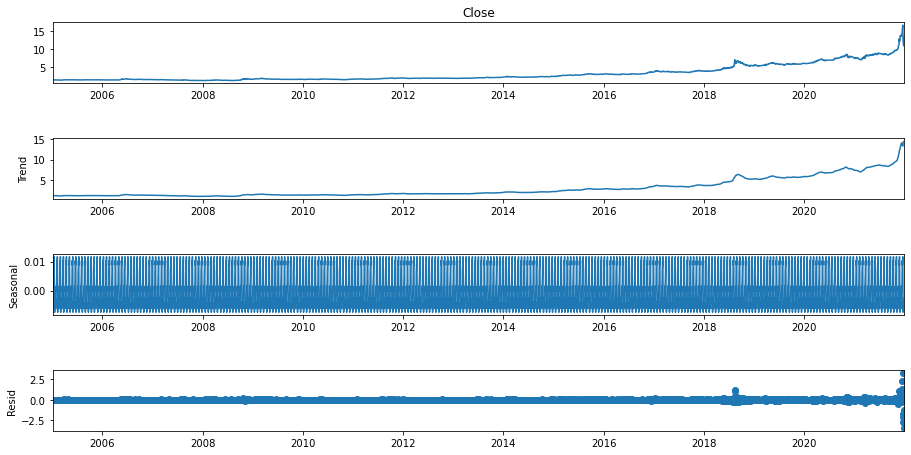

In [247]:
def seasonal_decompose(y,n):
    decomposition = sm.tsa.seasonal_decompose(x=y, model='additive',extrapolate_trend='freq', period=n)
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    return decomposition

decomposed = seasonal_decompose(y,16)

### Testing Stationarity

### Differenced, detrended and differenced & detrended version of data

### plot for Rolling Statistic (Z-Score) for testing Stationarity

In [248]:
def test_stationarity(timeseries, n, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=n).mean() 
    rolstd = pd.Series(timeseries).rolling(window=n).std()
    timeseries2 =  (timeseries - rolmean)/rolstd

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=timeseries.index, y=timeseries, name="Raw Data"))
    fig.add_trace(go.Scatter(x=timeseries2.index, y=timeseries2, name="Detrended Data (Window={}) (Z-Score)".format(n)))
    fig.add_trace(go.Scatter(x=rolmean.index, y=rolmean, name="Rolling Mean"))
    fig.add_trace(go.Scatter(x=rolstd.index, y=rolstd, name="Rolling Std (x10)"))
    return fig

test_stationarity(y, 16, 'raw data')

In [262]:
train = y.to_frame() # dataset to train
test = result["Close"].loc[(result.index>end)].drop_duplicates() # last X days for test  
predict_date = len(test) # the number of data points for the test set

In [263]:
train.index

DatetimeIndex(['2005-01-03', '2005-01-04', '2005-01-05', '2005-01-06',
               '2005-01-07', '2005-01-10', '2005-01-11', '2005-01-12',
               '2005-01-13', '2005-01-14',
               ...
               '2021-12-20', '2021-12-21', '2021-12-22', '2021-12-23',
               '2021-12-24', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=4435, freq='B')

In [264]:
train = train.asfreq(freq="B").dropna()
test = test.asfreq(freq="B").dropna()

In [265]:
train = train.asfreq(freq="B", method="ffill")
train.index

DatetimeIndex(['2005-01-03', '2005-01-04', '2005-01-05', '2005-01-06',
               '2005-01-07', '2005-01-10', '2005-01-11', '2005-01-12',
               '2005-01-13', '2005-01-14',
               ...
               '2021-12-20', '2021-12-21', '2021-12-22', '2021-12-23',
               '2021-12-24', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=4435, freq='B')

In [266]:
def HoltsWinter(train, seasonal_periods, trend, seasonal, predict_date):
    model = HWES(train, seasonal_periods=seasonal_periods, trend=trend, seasonal=seasonal)
    fitted = model.fit()

    # Print out the training summary.

    # print(fitted.summary())

    sales_forecast = fitted.forecast(steps=predict_date)
    mse = ((sales_forecast - test) ** 2).mean()
    print("The Root Mean Squared Error = {}".format(mse))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sales_forecast.index, y=sales_forecast.values, name="Forecasted"))
    fig.add_trace(go.Scatter(x=test.index, y=test.values, name="Test"))
    fig.show()
    return sales_forecast

In [274]:
def holt_win_sea(y,train,test,seasonal_type,seasonal_period,predict_date):
 
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive damped trend + multiplicative seasonal')
        mse2 = ((fcast2 - test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=test.index,
            y=test,
            name="test"       # this sets its legend entry
        ))

        fig.add_trace(go.Scatter(
            x=fcast1.index,
            y=fcast1,
            name="additive trend, additive seasonal"       # this sets its legend entry
        ))

        fig.add_trace(go.Scatter(
            x=fcast2.index,
            y=fcast2,
            name="additive damped trend, additive seasonal"       # this sets its legend entry
        ))

    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped_trend')
        mse4 = ((fcast3 - test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fig = go.Figure()
              
        fig.add_trace(go.Scatter(
            x=test.index,
            y=test,
            name="test"       # this sets its legend entry
        ))

        fig.add_trace(go.Scatter(
            x=fcast3.index,
            y=fcast3,
            name="additive trend, multiplicative seasonal"       # this sets its legend entry
        ))
        
        fig.add_trace(go.Scatter(
            x=fcast4.index,
            y=fcast4,
            name="additive damped trend, multiplicative seasonal"       # this sets its legend entry
        ))
            
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')
    return fig

In [273]:
HoltsWinter(train=train, seasonal_periods=16, trend="add", seasonal="mul", predict_date=predict_date)

The Root Mean Squared Error = 0.06194538133124917


2022-01-03    13.317485
2022-01-04    13.323692
2022-01-05    13.337150
2022-01-06    13.396893
2022-01-07    13.465034
2022-01-10    13.467745
2022-01-11    13.526677
Freq: B, dtype: float64

In [275]:
holt_win_sea(y, train,test,seasonal_type="additive",seasonal_period=5, predict_date=predict_date)

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=5 and a Box-Cox transformation 0.28
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=5 and a Box-Cox transformation 0.35


### get the date information of residuals (outliers)
   #### take Outliers with 10 max and 10 min values

In [288]:
residual_s = decomposed.resid.to_frame()
residual_s = residual_s.sort_values(by="resid")

In [289]:
px.box(residual_s)

In [290]:
min10 = residual_s.head(20)
max10 = residual_s.tail(20)
frames = [min10, max10]

minmax10 = pd.concat(frames).reset_index()
minmax10["Date"] = pd.to_datetime(minmax10["Date"], format='%Y-%m-%d')
dates = minmax10["Date"].dt.date.astype(str)

In [291]:
dates.values

array(['2021-12-27', '2021-12-28', '2021-12-24', '2021-12-29',
       '2021-12-23', '2021-12-30', '2021-12-22', '2021-12-31',
       '2021-11-16', '2021-03-19', '2021-11-15', '2021-11-17',
       '2018-08-06', '2020-11-16', '2021-11-12', '2018-08-09',
       '2021-12-09', '2021-11-26', '2018-08-27', '2021-12-08',
       '2021-03-31', '2018-09-05', '2021-12-06', '2020-11-06',
       '2020-11-05', '2021-03-09', '2021-03-22', '2020-11-09',
       '2018-08-31', '2021-12-02', '2018-08-15', '2021-12-03',
       '2021-12-01', '2021-12-15', '2021-11-24', '2018-08-13',
       '2018-08-14', '2021-12-16', '2021-12-17', '2021-12-20'],
      dtype=object)

## Read the csv file of aggregated news 

## Scraping the news about Turkey from Sputnik.news

In [309]:
def Scrape_Sputnik_News(url, scroll_num):
    driver = webdriver.Firefox()
    driver.get(url)
    driver.implicitly_wait(scroll_num)
    more_tag_button = "/html/body/div[2]/div[4]/div/div/div[1]/div[3]"

    for i in range(0, 10):  # here you will need to tune to see exactly how many scrolls you need
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight)')
        time.sleep(5)
        try:
            xpath_to_more = driver.find_element(By.XPATH, more_tag_button)
            xpath_to_more.click()
        except:
            time.sleep(2)
        continue
    html_source_code = driver.execute_script('return document.body.innerHTML;')

    time.sleep(5)

    html_soup = BeautifulSoup(html_source_code, 'html.parser')

    table = html_soup.find_all("div", class_="list__item")
    news_ls = []
    columnists_ls = []

    for i in table:
        title = i.find("a",class_="list__title")
        try:
            time_stamp = i.find("span",class_="date")
            tags = i.find_all("li",class_="tag")
            tag_ls = [i.find("a", class_="tag__text")["href"] for i in tags]
            new_tag = " ".join(tag_ls).replace("/", "").split(" ")
            news_ls.append((time_stamp.text, title.text, new_tag))
        except AttributeError:
            columnists_ls.append((title.text, tags))

    df = pd.DataFrame(news_ls)

    new_cols = ['Date', 'Title', 'Tags']

    new_names_map = {df.columns[i]: new_cols[i] for i in range(len(new_cols))}
    df.rename(new_names_map, axis=1, inplace=True)
    return df
df = Scrape_Sputnik_News(url="https://tr.sputniknews.com/search/?query=ekonomi", scroll_num=100)

In [310]:
df

,Date,Title,Tags
0,17:37,Yaş meyve ve sebze ihracatında Rusya ilk sırad...,[]
1,16:42,Rekabet Kurumu tarih verdi: 'Zincir marketlere...,[]
2,16:17,"Hazine ve Maliye Bakanı Nebati, TÜSİAD heyeti ...",[]
3,15:34,İngiltere'de enerji şirketinden vatandaşlara ı...,[]
4,14:00,Kılıçdaroğlu: Tefecilere hizmet eden kişinin a...,[]
...,...,...,...
330,"25 Aralık 2021, 12:50",İzmir'de hijyenik pedlerden alınan vergiler pr...,[]
331,"25 Aralık 2021, 12:24",TESK Başkanı Palandöken: Döviz kurlarındaki se...,[]
332,"25 Aralık 2021, 09:46",Bakan Nebati: Fiyatlar aşağı hızlı inecek yoks...,[]
333,"25 Aralık 2021, 01:56",Kur korumalı mevduatın tamamında stopajın sıf...,[]


In [292]:
news_df = pd.read_csv("Sputnik_News_Turkey.csv",index_col=0)
news_df.index = pd.to_datetime(news_df.index, format='%Y-%m-%d')
news_df["Date"] = news_df.index.date.astype(str)
news_df

,Title,Tags,Day,Week,Month,Year,Date
Date,,,,,,,
2021-12-31 20:11:00,"Benzin, motorin ve LPG'ye zam","['turkiye', 'keyword_Akaryakt', 'keyword_Zam']",31,52,12,2021,2021-12-31
2021-12-31 19:56:00,Vaka sayısı 40 bini aştı: 163 kişi hayatını ka...,"['turkiye', 'keyword_vaka', 'koronavirus', 'ko...",31,52,12,2021,2021-12-31
2021-12-31 19:13:00,Bakan Koca'dan Omicron açıklaması: Son 10 gün ...,"['turkiye', 'koronavirus-salgini', 'person_Fah...",31,52,12,2021,2021-12-31
2021-12-31 18:20:00,Altın fiyatları yılın son işlem gününü nasıl k...,"['turkiye', 'ekonomi', 'event_Ylba', 'keyword_...",31,52,12,2021,2021-12-31
2021-12-31 17:19:00,2021'de Türkiye gündemine damga vuran olaylar,"['turkiye', 'geo_Trkiye']",31,52,12,2021,2021-12-31
...,...,...,...,...,...,...,...
2021-05-11 15:58:00,Diyanet'ten Kudüs bildirgesi: Terör devleti İs...,"['turkiye', 'dunya', 'haberler', 'keyword_Kudu...",11,19,5,2021,2021-05-11
2021-05-11 15:52:00,Akşener'den '500 TL' çağrısı: Acil ihtiyaçları...,"['turkiye', 'haberler', 'dunya', 'person_Meral...",11,19,5,2021,2021-05-11
2021-05-11 15:42:00,"İşyerini açtı, üç gün üst üste ceza yedi: ‘Ceb...","['turkiye', 'dunya', 'haberler', 'geo_Trkiye',...",11,19,5,2021,2021-05-11


In [302]:
dates

0     2021-12-27
1     2021-12-28
2     2021-12-24
3     2021-12-29
4     2021-12-23
5     2021-12-30
6     2021-12-22
7     2021-12-31
8     2021-11-16
9     2021-03-19
10    2021-11-15
11    2021-11-17
12    2018-08-06
13    2020-11-16
14    2021-11-12
15    2018-08-09
16    2021-12-09
17    2021-11-26
18    2018-08-27
19    2021-12-08
20    2021-03-31
21    2018-09-05
22    2021-12-06
23    2020-11-06
24    2020-11-05
25    2021-03-09
26    2021-03-22
27    2020-11-09
28    2018-08-31
29    2021-12-02
30    2018-08-15
31    2021-12-03
32    2021-12-01
33    2021-12-15
34    2021-11-24
35    2018-08-13
36    2018-08-14
37    2021-12-16
38    2021-12-17
39    2021-12-20
Name: Date, dtype: object

In [301]:
df = news_df[news_df["Date"].isin(dates.values)]
df.sort_index()

,Title,Tags,Day,Week,Month,Year,Date
Date,,,,,,,
2021-11-12 00:05:00,"İTO Başkanı Avdagiç: Türkiye, dünyanın A Planı...","['turkiye', 'ekonomi', 'organization_Istanbul_...",12,45,11,2021,2021-11-12
2021-11-12 00:27:00,Türkiye ile Kazakistan arasında 'sınır ötesi m...,"['turkiye', 'dunya', 'geo_Kazakistan', 'keywor...",12,45,11,2021,2021-11-12
2021-11-12 09:30:00,Selvi: Erdoğan-Karamollaoğlu görüşmesinden rah...,"['turkiye', 'politika', 'person_Recep_Tayyip_E...",12,45,11,2021,2021-11-12
2021-11-12 09:43:00,İstanbul Büyükşehir Belediyesi: Mama kaplı ağa...,"['turkiye', 'yasam', 'geo_stanbul', 'organizat...",12,45,11,2021,2021-11-12
2021-11-12 10:25:00,Sanayi üretim endeksi eylülde aylık bazda yüzd...,"['turkiye', 'ekonomi', 'organization_Turkiye_I...",12,45,11,2021,2021-11-12
...,...,...,...,...,...,...,...
2021-12-31 17:19:00,2021'de Türkiye gündemine damga vuran olaylar,"['turkiye', 'geo_Trkiye']",31,52,12,2021,2021-12-31
2021-12-31 18:20:00,Altın fiyatları yılın son işlem gününü nasıl k...,"['turkiye', 'ekonomi', 'event_Ylba', 'keyword_...",31,52,12,2021,2021-12-31
2021-12-31 19:13:00,Bakan Koca'dan Omicron açıklaması: Son 10 gün ...,"['turkiye', 'koronavirus-salgini', 'person_Fah...",31,52,12,2021,2021-12-31


In [300]:
data=df.set_index("Date")["Tags"]

In [296]:
df = pd.DataFrame()

for _,row in data.iteritems():
    list_ = row.strip("[]").strip("''").replace("'","").replace("turkiye,","").strip().split(", ")
    df = df.append(list_)


dunya                         7797
haberler                      7528
geo_Trkiye                    2198
yasam                         1997
koronavirus                    898
geo_stanbul                    750
person_Recep_Tayyip_Erdoan     682
politika                       600
ekonomi                        472
geo_Rusya                      434
koronavirus-salgini            422
koronavirus-asisi              390
organization_AK_Parti          367
organization_CHP               361
spor                           302
kovid-19                       294
keyword_Orman_yangini          262
keyword_Yangin                 246
cevre                          244
geo_Antalya                    241
dtype: int64